# Reference
* https://deep-learning-study.tistory.com/807
* https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632

In [1]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.2 MB/s eta 0:00:00


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from torch import optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from torchvision import utils


from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
import numpy as np
import time
import copy
import random
from tqdm.notebook import tqdm
import math

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 데이터 처리

In [3]:
datapath = '/content/data'

if not os.path.exists(datapath):
  os.mkdir(datapath)

# STL10 data set 다운로드
train_set = datasets.STL10(datapath,split='train', download = True, transform=transforms.ToTensor())
test_set = datasets.STL10(datapath, split='test', download = True, transform=transforms.ToTensor())

print(len(train_set))
print(len(test_set))


100%|██████████| 2640397119/2640397119 [02:32<00:00, 17273920.54it/s]


Extracting /content/data/stl10_binary.tar.gz to /content/data
Files already downloaded and verified
5000
8000


In [4]:

# 이미지 변형 틀 정의
# tensor 형식 + 224로 resize
transformation = transforms.Compose([transforms.ToTensor(),transforms.Resize(224)])

# data set에 적용
train_set.transform = transformation
test_set.transform = transformation

# data loader 정의
train_dl = DataLoader(train_set, batch_size=32, shuffle=True)
test_dl = DataLoader(test_set, batch_size=64, shuffle=True)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


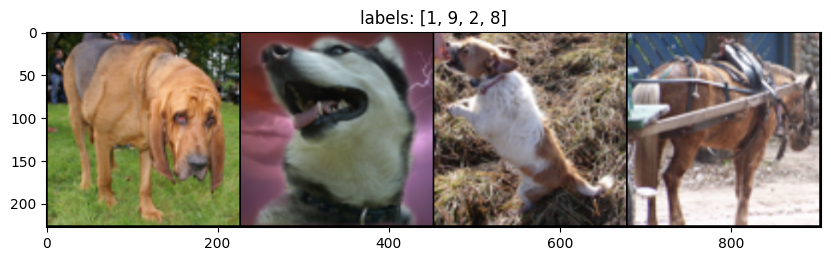

In [5]:
#예시 이미지 출력
def show_img(img,y=None):
  npimg = img.numpy()
  npimg_tr = np.transpose(npimg,(1, 2, 0))
  plt.imshow(npimg_tr)

  if y is not None:
    plt.title('labels: ' + str(y))

np.random.seed(1)
torch.manual_seed(0)

grid_size=4
rnd_ind = np.random.randint(0, len(train_set), grid_size)

x_grid = [train_set[i][0] for i in rnd_ind]
y_grid = [test_set[i][1] for i in rnd_ind]

x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)
plt.figure(figsize=(10,10))
show_img(x_grid, y_grid)

# ViT 구현

patch embedding

In [6]:
# patch embedding 구현
# 2D 이미지를 일정 크기의 patch로 나눈다음에 이 patch들을 flat 시킴
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels=3, patch_size=16,emb_size=768, img_size=224):
    super().__init__()
    self.patch_size = patch_size

    self.projection = nn.Sequential(
      Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
      nn.Linear(patch_size * patch_size * in_channels, emb_size)
    )

    # cls token, position embedding 정의
    self.cls_token = nn.Parameter(torch.randn(1,1,emb_size))
    self.positions = nn.Parameter(torch.randn((img_size//patch_size)**2 + 1, emb_size))

  def forward(self,x):
    b = x.shape[0]
    x = self.projection(x)
    cls_tokens = repeat(self.cls_token, '() n e -> b n e',b=b)
    x = torch.cat([cls_tokens, x], dim = 1)
    x += self.positions
    return x

In [7]:
# patch embedding test
x = torch.randn(16, 3, 224, 224)
patch_embedding = PatchEmbedding()
patch_output = patch_embedding(x)
print('[batch, 1+num of patches, emb_size] = ', patch_output.shape)

[batch, 1+num of patches, emb_size] =  torch.Size([16, 197, 768])


multi head attention

In [8]:
# Multi-Head Attention

class MultiHeadAttention(nn.Module):
  def __init__(self, emb_size=768, num_heads=8, dropout=0):
    super().__init__()
    self.emb_size = emb_size
    self.num_heads = num_heads
    self.keys = nn.Linear(emb_size, emb_size)
    self.queries = nn.Linear(emb_size, emb_size)
    self.values = nn.Linear(emb_size, emb_size)
    self.att_drop = nn.Dropout(dropout)
    self.projection = nn.Linear(emb_size, emb_size)

  def forward(self, x, mask=None):
    # key , query, value로 나누기
    # b, 197, 728 -> b, 8, 197, 91
    queries = rearrange(self.queries(x), 'b n (h d) -> b h n d', h=self.num_heads)
    keys = rearrange(self.keys(x), 'b n (h d) -> b h n d', h=self.num_heads)
    values = rearrange(self.values(x), 'b n (h d) -> b h n d', h=self.num_heads)
    
    # matrix multiplication between queries and keys
    energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_head, query_len, key_len

    if mask is not None:
      fill_value = torch.finfo(torch.float32).min
      energy.mask_fill(-mask,fill_value)

    scaling = self.emb_size ** (1/2)
    att = F.softmax(energy, dim=-1) / scaling
    att = self.att_drop(att)

    out = torch.einsum('bhal, bhlv -> bhav', att, values)
    out = rearrange(out, 'b h n d -> b n (h d)')
    out = self.projection(out)
    return out

In [9]:
# MultiHeadAttention test
MHA = MultiHeadAttention()
MHA_output = MHA(patch_output)
print(MHA_output.shape)

torch.Size([16, 197, 768])


residual

In [10]:
# Residual

class ResidualAdd(nn.Module):
  def __init__(self, fn):
    super().__init__()
    self.fn = fn

  def forward(self, x, **kwargs):
    res = x
    x = self.fn(x, **kwargs)
    x += res
    return x

Feed Forward Block

In [11]:
#Feed Foward Block
class FeedForwardBlock(nn.Sequential):
  def __init__(self, emb_size, expansion=4, drop_p=0):
    super().__init__(
        nn.Linear(emb_size,expansion*emb_size),
        nn.GELU(),
        nn.Dropout(drop_p),
        nn.Linear(expansion * emb_size, emb_size),
    )
    

In [12]:
# test
x = torch.randn(16,1,128)
model = FeedForwardBlock(128)
output = model(x)
print(output.shape)

torch.Size([16, 1, 128])


Encoder

In [13]:
class TransformerEncoderBlock(nn.Sequential):
  def __init__(self, emb_size=768, drop_p=0., forward_expansion=4, forward_drop_p=0., **kwargs):
    super().__init__(
        ResidualAdd(nn.Sequential(
            nn.LayerNorm(emb_size),
            MultiHeadAttention(emb_size, **kwargs),
            nn.Dropout(drop_p)
        )),
        ResidualAdd(nn.Sequential(
            nn.LayerNorm(emb_size),
            FeedForwardBlock(emb_size, **kwargs),
            nn.Dropout(drop_p)
        ))
    )

In [14]:
# TransformerEncoderBlock test
model = TransformerEncoderBlock()
output = model(patch_output)
print(output.shape)

torch.Size([16, 197, 768])


Transformer 

In [15]:
class TransformerEncoder(nn.Sequential):
  def __init__(self, depth=12, **kwargs):
    super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [16]:
#TransformerEncoder test
model = TransformerEncoder()
output = model(patch_output)
print(output.shape)

torch.Size([16, 197, 768])


Classification Head

In [17]:
#Classification Head
class ClassificationHead(nn.Sequential):
  def __init__(self, emb_size=768, n_classes=10):
    super().__init__(
        Reduce('b n e -> b e', reduction='mean'),
        nn.LayerNorm(emb_size),
        nn.Linear(emb_size, n_classes)
    )

In [18]:
# Classification Head test
x = torch.randn(16, 1, 768)
model = ClassificationHead()
output = model(x)
print(output.shape)

torch.Size([16, 10])


ViT

In [19]:
# ViT
class ViT(nn.Sequential):
  def __init__(self, in_channels=3, patch_size=16,emb_size=768,img_size=224,depth=12,n_classes=10, **kwargs):
    super().__init__(
        PatchEmbedding(in_channels, patch_size, emb_size, img_size),
        TransformerEncoder(depth, emb_size=emb_size, **kwargs),
        ClassificationHead(emb_size, n_classes)
    )


In [20]:
# ViT test
x = torch.randn(16,3,224,224)
model = ViT()
output = model(x)
print(output.shape)

torch.Size([16, 10])


Training

In [26]:
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)

In [27]:
# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [28]:
# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b

# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb
        yb = yb
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric

In [29]:
# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [30]:
# define the training parameters
params_train = {
    'num_epochs':100,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':test_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error')
createFolder('./models')

In [ ]:
# Start training
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/99, current lr= 0.01
